In [1]:
# Imports
import torch
from torch.distributions import Normal,Uniform,Gamma,Laplace,OneHotCategorical,StudentT,HalfNormal,HalfCauchy
import os
import time
from functools import partial

from causal_cocycle.model import cocycle_model,flow_model,flow_outcome_model
from causal_cocycle.optimise import *
from causal_cocycle.loss_functions import Loss
from causal_cocycle.conditioners import Empty_Conditioner,Constant_Conditioner,Lin_Conditioner,NN_RELU_Conditioner
from causal_cocycle.transformers import Transformer,Shift_layer,Scale_layer,RQS_layer,Inverse_layer
from causal_cocycle.helper_functions import likelihood_loss,mmd,propensity_score
from causal_cocycle.kernels import *
from causal_cocycle.kde import *

from BD import *


#Shorthand function calls
def NN(i,o=2,width=128,layers=2):
    return NN_RELU_Conditioner(width = width,
                                     layers = layers, 
                                     input_dims =  i, 
                                     output_dims = o,
                                     bias = True)
def C(rows,cols,value):
    return Constant_Conditioner(init = torch.ones((rows,cols))*value)

T = partial(Transformer,logdet = True)

In [2]:
# DGP set up
seed = 0 
N = 5000
D = 10
Zcorr = 0.0
flip_prob = 0.00
coeffs = 1/torch.linspace(1,D,D)[:,None]**1
coeffs *= 1/coeffs.sum()
means = torch.tensor([[-2, 0]]).T # means for mixture U dist
scales = torch.tensor([[-1.0, 1.0]]).T  # variances for mixture U dist
probabilities = torch.tensor([1/2,1/2]) # mixture probs for mixture U dist
base_dists = [HalfNormal(1),HalfCauchy(1)]
noise_dist = Mixture1D(base_dists,probabilities,means,scales)
Zdist1 = Normal(0,1.5)
Zdist2 = Normal(0,1.5)
feature = lambda x,t: (torch.sigmoid(x)<=t.T).float()

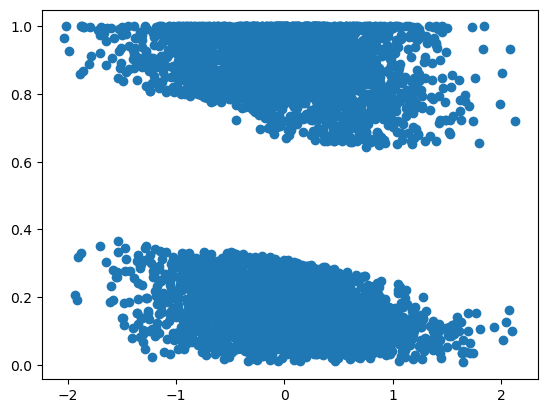

In [3]:
# Visualizing data
Z1,X1,Y1 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist1,noise_dist)
plt.scatter(Z1 @ coeffs,torch.sigmoid(Y1));

In [4]:
# Method + opt set up
base_distribution = StudentT(10,0,1)
#base_distribution = Laplace(0,1)
batch_size = 64
validation_method = "CV"
layers = 2
width = 128
train_val_split = 0.5
learn_rate = [1e-3]
scheduler = True
maxiter = 10000
miniter = 10000
weight_decay = 1e-3
RQS_bins = 8

In [5]:
# Setting training optimiser args
opt_args = ["learn_rate",
            "scheduler",
            "batch_size",
            "maxiter",
            "miniter",
            "weight_decay",
            "print_",
            "likelihood_param_opt"]
opt_argvals = [learn_rate,
              scheduler,
              batch_size,
             maxiter,
              miniter,
              weight_decay,
              True,
              True]

In [6]:
# Specifying models for cross-validation

# Specifying list of hypers to construct models from
hypers = ["weight_decay"]
hypers_list = [[1e-3]]
conditioners_list = [[NN(D+1,1,width,layers),C(1,1,1),C(1,3*RQS_bins + 2,3)],
                          [NN(D+1,1,width,layers),NN(D+1,1,width,layers),C(1,3*RQS_bins + 2,3)],
                          [NN(D+1,1,width,layers),NN(D+1,1,width,layers),NN(D+1,3*RQS_bins + 2,width,layers)]]
transformers_list = [Transformer([Shift_layer(),Scale_layer(),RQS_layer(RQS_bins)],logdet = True),
                           Transformer([Shift_layer(),Scale_layer(),RQS_layer(RQS_bins)],logdet = True),
                           Transformer([Shift_layer(),Scale_layer(),RQS_layer(RQS_bins)],logdet = True)]

# Constructing all model combinations
models_validation = []
hyper_argvals = []
for m in range(len(conditioners_list)):
    for hyper in hypers_list:
        for hyper_value in hyper:
            models_validation.append(flow_model(conditioners_list[m],transformers_list[m]))
            hyper_argvals.append([hyper_value])
hyper_args = [hypers]*len(hyper_argvals)

In [7]:
# DGP
torch.manual_seed(seed)
Z1,X1,Y1 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist1,noise_dist)
Z2,X2,Y2 = DGP(N,D,partial(policy,flip_prob = flip_prob),coeffs,Zcorr,Zdist2,noise_dist)
Z,X,Y = (torch.row_stack((Z1,Z2)),
         torch.row_stack((X1,X2)),
         torch.row_stack((Y1,Y2)))
id = torch.randperm(Z.size(0))
Z,X,Y = Z[id],X[id],Y[id]

In [8]:
# Getting loss functon and training model
loss_fn =  likelihood_loss(base_distribution, tail_adapt = True)
final_models,val_losses = validate(models_validation,
                                         loss_fn,
                                         X,
                                         Y,
                                         [],
                                         validation_method,
                                         train_val_split,
                                         opt_args,
                                         opt_argvals,
                                         hyper_args,
                                         hyper_argvals,
                                         choose_best_model = "per fold")
for k in range(len(final_models)):
    final_models[k].transformer.logdet = False

Training loss last 10 avg is : tensor(2.2644)
99.9  % completion
Currently optimising model  2 , for fold  1


In [9]:
val_losses

tensor([[2.5306, 2.5598],
        [2.3814, 2.1845],
        [2.3173, 2.3079]])

In [14]:
# Defining outcome model and feature of interest (i.e. cdf)
nintsample = 5000
feature = lambda x,t: (torch.sigmoid(x)[None]<= t[...,None]).float()
Usample = base_distribution.sample((nintsample,1))
conditional_mean_model1 = flow_outcome_model(final_models[1],Usample)
conditional_mean_model2 = flow_outcome_model(final_models[0],Usample)

In [15]:
# Sampling from interventional distribution
torch.manual_seed(seed)
Zint1,Xint1,Yint1 = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist1,noise_dist)
Zint2,Xint2,Yint2 = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist2,noise_dist)

In [16]:
# Drawing counterfactual outcomes
Yint1pred = final_models[1].cocycle(Xint1,X1,Y1).detach()
Yint2pred = final_models[0].cocycle(Xint2,X2,Y2).detach()

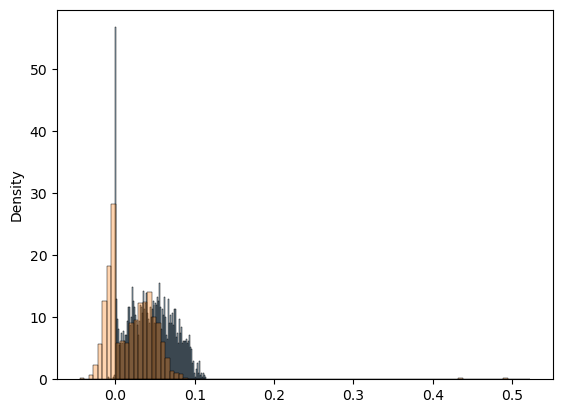

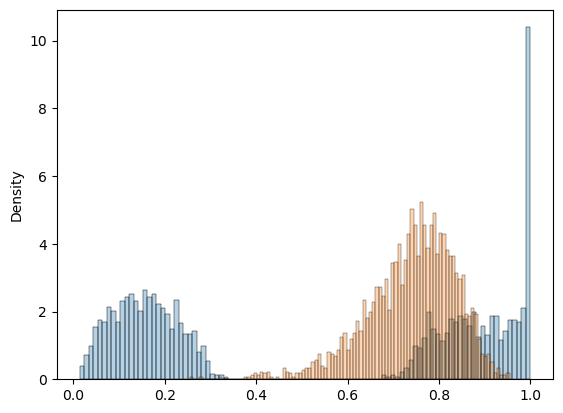

In [20]:
import seaborn as sns
counterfactual_diffs = torch.concatenate((((torch.sigmoid(Yint2[X2[:,0]==2])-torch.sigmoid(Y2[X2[:,0]==2]))[:,0]),
                                         ((torch.sigmoid(Yint1[X1[:,0]==2])-torch.sigmoid(Y1[X1[:,0]==2]))[:,0])))
counterfactual_diffpreds = torch.concatenate((((torch.sigmoid(Yint2pred[X2[:,0]==2])-torch.sigmoid(Y2[X2[:,0]==2]))[:,0]),
                                         ((torch.sigmoid(Yint1pred[X1[:,0]==2])-torch.sigmoid(Y1[X1[:,0]==2]))[:,0])))
sns.histplot(counterfactual_diffs, bins=100, alpha=0.33, stat = "density")
sns.histplot(counterfactual_diffpreds, bins=100, alpha=0.33, stat = "density")
plt.show()

# Sampling from interventional distribution
torch.manual_seed(seed)
Zint1,Xint1,Yint1gen = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist1,base_distribution)
Zint2,Xint2,Yint2gen = DGP(nintsample,D,partial(new_policy),coeffs,Zcorr,Zdist2,base_distribution)

int = torch.concatenate((torch.sigmoid(Yint1[X1[:,0]==2])[:,0],
                         torch.sigmoid(Yint2[X2[:,0]==2])[:,0]
                        ))
intpreds = torch.concatenate((torch.sigmoid(Yint1gen[X1[:,0]==2])[:,0],
                         torch.sigmoid(Yint2gen[X2[:,0]==2])[:,0]
                        ))
sns.histplot(int, bins=100, alpha=0.33, stat = "density")
sns.histplot(intpreds, bins=100, alpha=0.33, stat = "density")
plt.show()

In [10]:
# cdf values
t = torch.linspace(0,1,1000)[:,None]

# scm model cdf
batch = 100
nbatch = int(len(t)/batch)
scm_cdf_int1 = torch.zeros(len(t))
scm_cdf_int2 = torch.zeros(len(t))
for i in range(nbatch):
    scm_cdf_int1[i*batch:(i+1)*batch] = conditional_mean_model1(Xint1,
                                                partial(feature,t = t[i*batch:(i+1)*batch])).mean(1)
    scm_cdf_int2[i*batch:(i+1)*batch] = conditional_mean_model2(Xint2,
                                                partial(feature,t = t[i*batch:(i+1)*batch])).mean(1)
    
    print("getting cdf value batch ",i+1,"/",nbatch)

# True cdf
true_cdf_int1 = feature(Yint1,t).mean((1,2))
true_cdf_int2 = feature(Yint2,t).mean((1,2))

getting cdf value batch  1 / 10
getting cdf value batch  2 / 10
getting cdf value batch  3 / 10
getting cdf value batch  4 / 10
getting cdf value batch  5 / 10
getting cdf value batch  6 / 10
getting cdf value batch  7 / 10
getting cdf value batch  8 / 10
getting cdf value batch  9 / 10
getting cdf value batch  10 / 10


In [11]:
# Training propensity score models
Propensity_score_model_est = []
Propensity_score_model_policy = []
Propensity_score_model_new_policy = []

# Estimating mistake probabilities
Xtrue = policy(Z)
states = torch.unique(X[:,0]).int()
nstate = len(states)
P = torch.zeros((nstate,nstate))
for i in range(nstate):
    for j in range(nstate):
        P[i,j] = ((X[:,0]==states[i])*(Xtrue[:,0]==states[j])).float().sum()
P *= 1/P.sum(0)

propensity_model_est = propensity_score(P,policy)
propensity_model_new_policy = propensity_score(torch.eye(len(P)),new_policy)  
propensity_model_policy = propensity_score(torch.eye(len(P)),policy) 

In [12]:
# Getting IPW estimator
weights_int1 = (propensity_model_new_policy(X1,Z1)/
                propensity_model_est(X1,Z1)).detach()

weights_int2 = (propensity_model_new_policy(X2,Z2)/
                propensity_model_est(X2,Z2)).detach()

weights_int1 *= len(weights_int1)/weights_int1.sum()
weights_int2 *= len(weights_int2)/weights_int2.sum()

IPW_cdf_int1 = (weights_int1[None,:,None]*feature(Y1,t)).mean((1,2))
IPW_cdf_int2 = (weights_int2[None,:,None]*feature(Y2,t)).mean((1,2))

In [13]:
# Getting DR estimator (start by adding on IPW term to outcome model
scm_DR_cdf_int1 = scm_cdf_int1 + IPW_cdf_int1
scm_DR_cdf_int2 = scm_cdf_int2 + IPW_cdf_int2

for i in range(nbatch):
    # Getting batch of conditional means and propensity weights
    conditional_mean_batch1 = conditional_mean_model1(Xint1,partial(feature,t = t[i*batch:(i+1)*batch]))
    conditional_mean_batch2 = conditional_mean_model2(Xint2,partial(feature,t = t[i*batch:(i+1)*batch]))

    # Updating DR estimator
    scm_DR_cdf_int1[i*batch:(i+1)*batch] -= (weights_int1*conditional_mean_batch1).mean(1)
    scm_DR_cdf_int2[i*batch:(i+1)*batch] -= (weights_int2*conditional_mean_batch2).mean(1)

    print("getting cdf value batch ",i+1,"/",nbatch)   

getting cdf value batch  1 / 10
getting cdf value batch  2 / 10
getting cdf value batch  3 / 10
getting cdf value batch  4 / 10
getting cdf value batch  5 / 10
getting cdf value batch  6 / 10
getting cdf value batch  7 / 10
getting cdf value batch  8 / 10
getting cdf value batch  9 / 10
getting cdf value batch  10 / 10


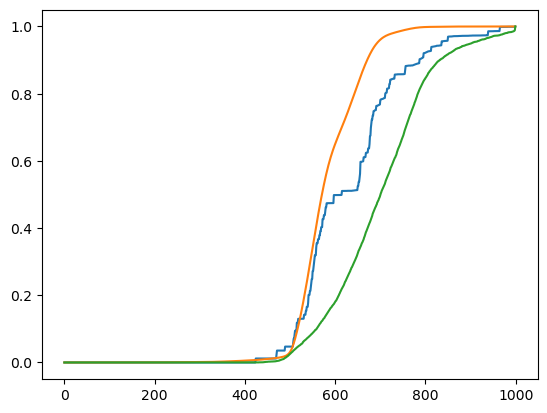

In [14]:
plt.plot(IPW_cdf_int2)
plt.plot(scm_cdf_int2)
plt.plot(true_cdf_int2)

In [15]:
print((scm_cdf_int1 -true_cdf_int1).abs().mean())
print((IPW_cdf_int1 -true_cdf_int1).abs().mean())
print((scm_DR_cdf_int1 -true_cdf_int1).abs().mean())

print((scm_cdf_int2 -true_cdf_int2).abs().mean())
print((IPW_cdf_int2 -true_cdf_int2).abs().mean())
print((scm_DR_cdf_int2 -true_cdf_int2).abs().mean())

tensor(0.0851)
tensor(0.0363)
tensor(0.0333)
tensor(0.1176)
tensor(0.0695)
tensor(0.0707)
